# Assignment 08

## Dimensionality Reduction 

## CSCI E-108

### Steve Elston

> Instructions: For this assignment you will complete the exercises shown. All exercises involve creating and executing some Python code. Additionally, most exercises have questions for you to answer. You can answer questions by creating a Markdown cell and writing your answer. If you are not familiar with Markdown, you can find a brief tutorial here.

## Introduction  

Dimensionality reduction algorithms are widely used in data mining. Human perception of relationships in data is limited beyond a few dimensions. Further, many data mining algorithms produce poor results where when there is significant dependency between the features or variables. In both cases, we can apply dimensionality reduction methods.   

In the exercises in this notebook you will gain some experience working with some commonly used dimensionality reduction methods. Specifically, there are two distinct classes of algorithms you will explore:    
1. **Dimensionality reduction transformation methods** create operators to map a sample (feature) space to an orthogonal space. Typically the original data can be well-represented in lower dimensions in the orthogonal space. Examples of these methods include principle component analysis (PCA) and kernel principle component analysis (Kernal PCA).    
2. **Manifold learning methods** where data in a high dimensional space is mapped onto a 2-dimensional manifold. Manifold learning is primarily used to aid visualization of high-dimensional data.  

To begin, execute the code in the cell below to import the packages you will need. 

In [128]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import SpectralEmbedding, MDS, TSNE
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import random_projection
import umap
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import math
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import umap

## A Synthetic Example

To make the ideas of dimensionality reduction clear, we start with an extremely simple example. In this example, dimensionality reduction is applied to bivariate Normally distributed data. The code in the cell below does the following:  
1. Generate 500 samples from a bivariate, zero-centered Normal distribution with covariance having a high degree of dependency between the variables:  
$$
cov = 
 \begin{bmatrix}
   1.0 & 0.9\\
   0.9 & 1.0
   \end{bmatrix}
$$
2. Print the empirical covariance matrix of the sample.  
3. Plot the simulated data values.

Execute this code.

The emperical covariance
[[1.02657695 0.91440274]
 [0.91440274 0.99100602]]


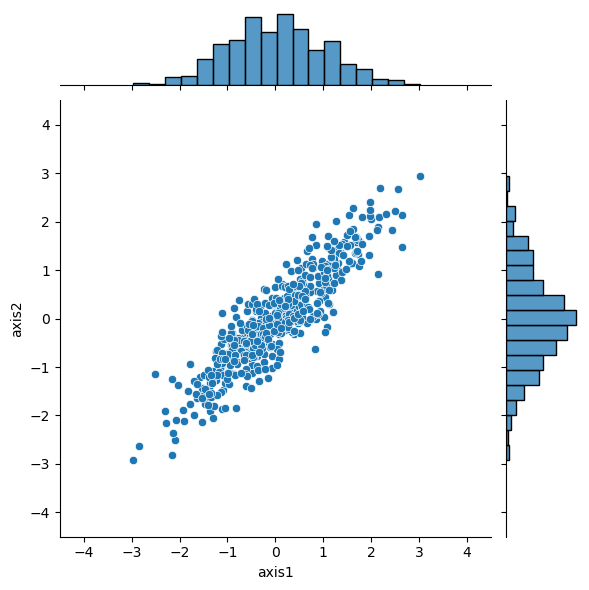

In [129]:
def plot_normal(X):
    X = pd.DataFrame(X, columns=['axis1','axis2'])
    _=sns.jointplot(x='axis1', y='axis2', data=X, xlim=(-4.5,4.5), ylim=(-4.5,4.5))

cov = [[1, 0.9], [0.9, 1]]
np.random.seed(367)
Normal_random = np.random.multivariate_normal([0.0,0.0], cov, size=500)
print('The emperical covariance')
print(np.cov(Normal_random[:,0], Normal_random[:,1]))
plot_normal(Normal_random)

Notice the following aspects of these results:  
1. The empirical covariance matrix is very close in values to the covariance matrix used for the simulation.   
2. The scatter plot shows considerable dependency between the two variables. 
3. The marginal distributions of the two variables appear to be close to Normally distributed. 

Next, the code in the cell below does the following.  
1. A PCA object is instantiated and the data fit.   
2. The PCA model is used to transform or project the original data matrix into the new coordinate system.    
3. The empirical covariance is computed and printed. 
4. **Variance ratio** of the two dimensions of the new space is computed and printed. Here, variance ratio is the variance on each dimension of the space divided by the total variance of the data. 
5. A plot of the projected data values in the new coordinate space is plotted. 

Execute this code. 

Covariance of the transformed data
[[ 1.92336718e+00 -4.43199252e-16]
 [-4.43199252e-16  9.42157896e-02]]

The variance explained ratio = [0.95330264 0.04669736]


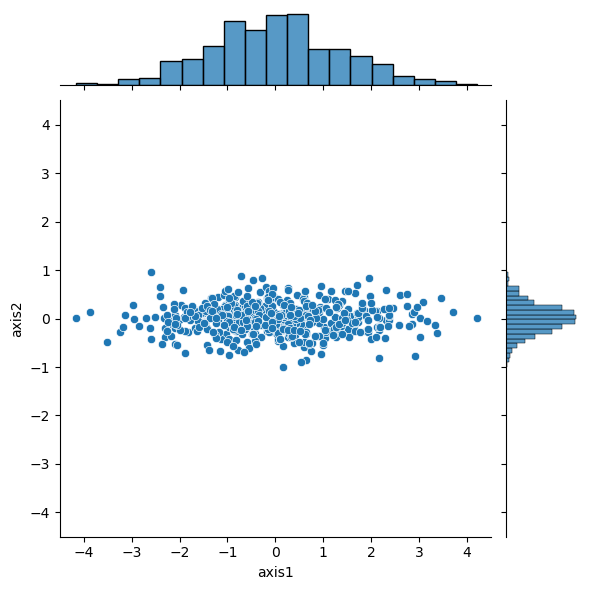

In [130]:
Normal_pca = PCA().fit(Normal_random)
simple_pca = Normal_pca.transform(Normal_random)
print('Covariance of the transformed data')
print(np.cov(simple_pca[:,0], simple_pca[:,1]))
print(f"\nThe variance explained ratio = {Normal_pca.explained_variance_ratio_}")
plot_normal(simple_pca)

The PCA transformation of these data appears to have worked as expected. Notice the following:  
1. The diagonal terms of the covariance matrix are significantly different in value, indicating that the first component (axis) projects the majority of the variance of the data.  
2. The off-diagonal terms of the covariance matrix are effectively 0, indicating there is no dependency between the variables in the new coordinate system. 
3. The observation that most of the variability of the projected data are explained by the first component is confirmed by both the variance ratio values and the scatter plot. 
4. The marginal distributions of the two variables are very close to Normal, but with significantly difference scale or variance. 

## First Running Example  

We will now start working with some simple real-world data. The famous Iris dataset was collected by a botanist named Edgar Anderson around 1935. Subsequently, the dataset became famous in data analysis circles when Ronald A Fisher used it as an example for his seminal 1936 paper on discriminate analysis, one of the first true multivariate statistical methods proposed. By modern standards this data set is small (only 150 samples) and simple (only 4 features), but the simplicity will help in understand the methods at hand.   

The code in the cell below loads the data set and transforms it into a de-meaned Pandas data frame with human readable column and species names. Execute this code. 

In [131]:
iris_data = load_iris()

## Normalize the data values  
temp = (iris_data['data'] - iris_data['data'].mean(axis=0)) / iris_data['data'].std(axis=0)

## Prepare the data frame 
target_species = {0:'Setosa',1:'Versicolour',2:'Virginica'}
species = [target_species[x] for x in iris_data['target']]
iris = pd.DataFrame(temp, columns=['sepal_length','sepal_width','petal_length','petal_width'])
iris['species'] = species
iris_data = temp
iris

sepal_length  sepal_width  petal_length  petal_width    species
0       -0.900681     1.019004     -1.340227    -1.315444     Setosa
1       -1.143017    -0.131979     -1.340227    -1.315444     Setosa
2       -1.385353     0.328414     -1.397064    -1.315444     Setosa
3       -1.506521     0.098217     -1.283389    -1.315444     Setosa
4       -1.021849     1.249201     -1.340227    -1.315444     Setosa
..            ...          ...           ...          ...        ...
145      1.038005    -0.131979      0.819596     1.448832  Virginica
146      0.553333    -1.282963      0.705921     0.922303  Virginica
147      0.795669    -0.131979      0.819596     1.053935  Virginica
148      0.432165     0.788808      0.933271     1.448832  Virginica
149      0.068662    -0.131979      0.762758     0.790671  Virginica

[150 rows x 5 columns]

Since there are only 4 features in this dataset a pairs plot will help with understanding the relationships in these data. Execute the code below to display the plot. 

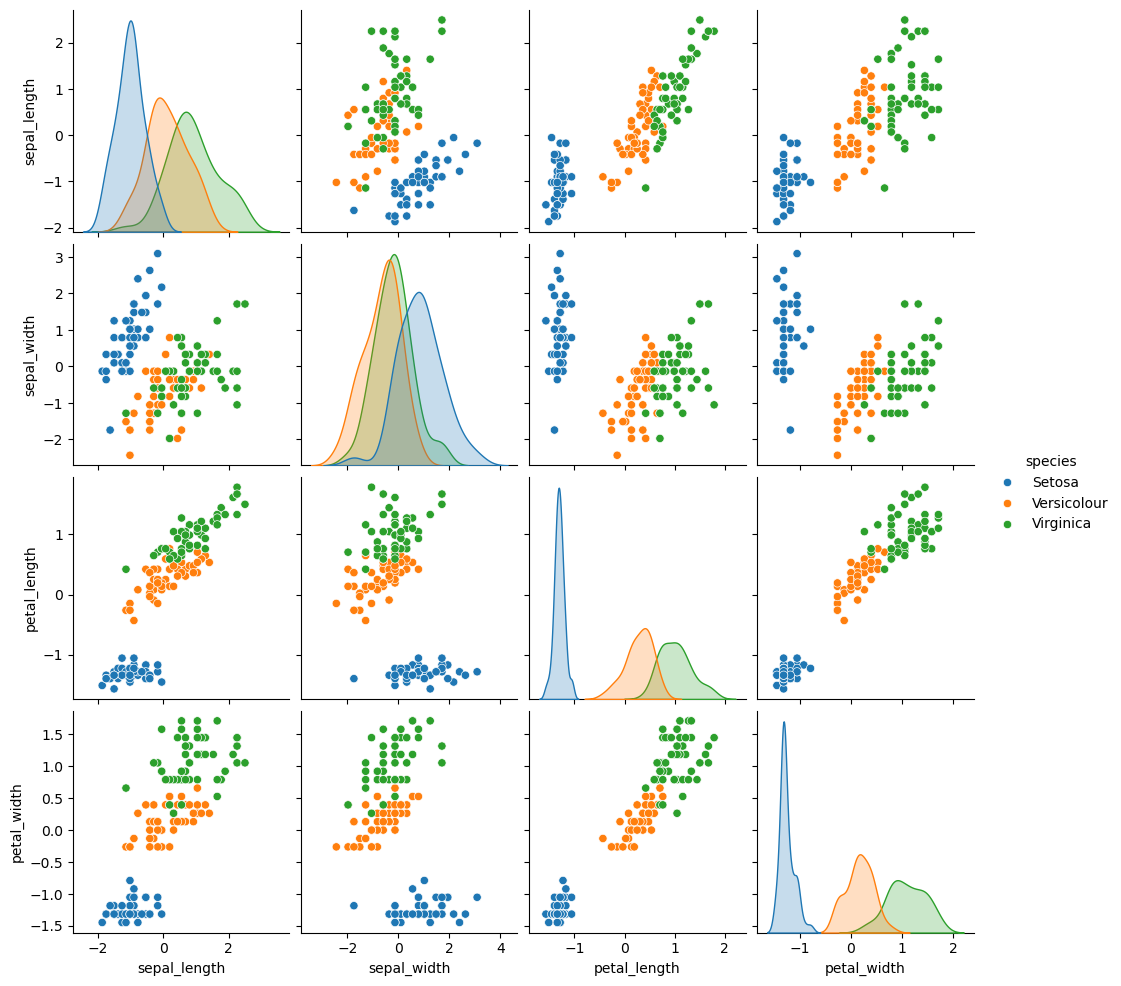

In [132]:
_=sns.pairplot(iris, hue='species')

Examine this plot array. You can see that values samples for the Setosa species are well separated. However there is some overlap between samples from Versicolour and Virginica. Further, and more importantly, it appears that these is considerable redundancy in these plots. This leads one to suspect that there is a high dependency between these cases.  

We can further investigate the dependency between the variables by computing the covariance matrix. Execute the code in the cell below to compute the covariance matrix of the iris data. 

Iris covariance matrix
              sepal_length  sepal_width  petal_length  petal_width
sepal_length      1.006711    -0.118359      0.877604     0.823431
sepal_width      -0.118359     1.006711     -0.431316    -0.368583
petal_length      0.877604    -0.431316      1.006711     0.969328
petal_width       0.823431    -0.368583      0.969328     1.006711


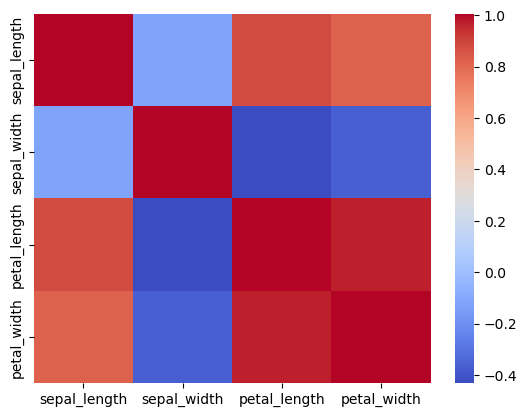

In [133]:
iris_convariance = pd.DataFrame(np.cov(np.transpose(iris_data)), index=list(iris.columns)[:-1], columns=list(iris.columns)[:-1])
print('Iris covariance matrix')
print(iris_convariance)
sns.heatmap(iris_convariance, cmap='coolwarm');

Several of the off-diagonal terms of the covariance matrix are far from zero. We can conclude that there is significant dependency between the variables.   

## Compute PCA of the iris data   

The first algorithm you will apply to the iris data is linear PCA.  

> **Exercise 08-1:** Compute the PCA of the iris data and plot the explained variance of the components by the following steps:  
> 1. Instantiate a Scikit-learn PCA model object with [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).  
> 2. Fit the model to `iris_data` numpy array using the `fit` method on the model object.  
> 3. Display a scatterplot of with the `explained_variance_ratio_` attribute of the fitted model vs. the component number.  

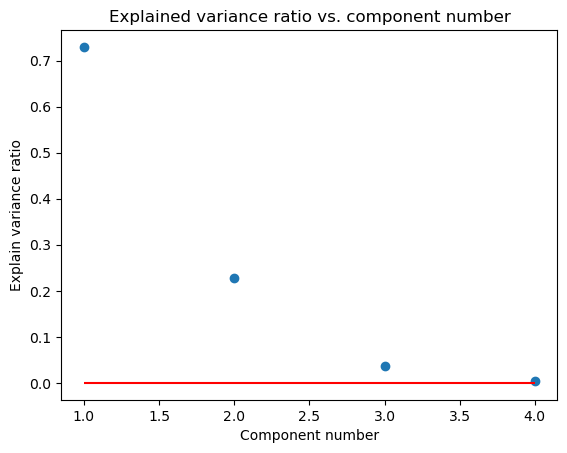

In [134]:
def plot_variance_ratio(pca_model, n_components):   
    _=plt.scatter(range(1, n_components + 1), pca_model.explained_variance_ratio_)    
    _=plt.hlines(0,1,n_components, color='red')
    _=plt.xlabel('Component number')
    _=plt.ylabel('Explain variance ratio')
    _=plt.title('Explained variance ratio vs. component number')

## Put your code below 

# Instantiate a PCA model object
iris_pca = PCA()

# Fit the model to the iris data
iris_pca.fit(iris_data)

# Display the results
n_components = 4
plot_variance_ratio(iris_pca, n_components)

> Examine the plot and answer these questions: 
> 1. Does it appear that much of the variance in the data is explained by the first component and why?  
> 2. Is there any substantial difference in the variance explained between the second and third and fourth components?   

> **Answers:**    
> 1.  Yes, it appears that much of the variance in the data is explained by the first component given the high ratio (vs other component numbers). In PCA, the first component is chosen to capture the maximum variance in the data, and it typically explains a significant portion of the total variance.     
> 2.  There is, though much less than the first component, which indicates there is small amounts of additional information each subsequent component contributes.

> Recall that the variance of the components from the PCA goes as the square of the singular values. You can gain another view of the relationship between the principle components by executing the code below to plot the singular values. 

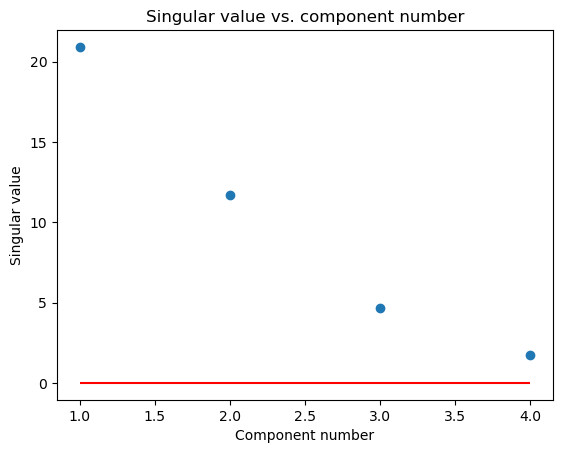

In [135]:
_=plt.scatter(range(1, len(iris_pca.singular_values_) + 1), iris_pca.singular_values_)
_=plt.hlines(0,1,len(iris_pca.singular_values_), color='red')
_=plt.xlabel('Component number')
_=plt.ylabel('Singular value')
_=plt.title('Singular value vs. component number')

> 3. Are these singular values consistent with the variance explained for the components? 
> **End of exercise.**

> **Answer 3:** Yes, they are consistent. Components with higher singular values tend to explain more variance in the data, while those with lower singular values explain less variance.       

Next, you will investigate the principle components used to project the data into the new space. Execute the code in the cell below to print the components.  

In [136]:
components = iris_pca.components_
components

array([[ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654],
       [ 0.37741762,  0.92329566,  0.02449161,  0.06694199],
       [ 0.71956635, -0.24438178, -0.14212637, -0.63427274],
       [-0.26128628,  0.12350962,  0.80144925, -0.52359713]])

The components are in the columns of this array. These components are the projections of the origianl sample space onto the orthogonal space.  

> **Exercise 08-2:** The principle components must be unitary, unit norm, and orthogonal. Do the following to verify these properties.  
> 1. In the first cell below compute and print the Euclidean norm of these of the components using [numpy.linalg.norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html).    
> 2. Using [itertools.combinations](https://docs.python.org/3/library/itertools.html) compute the dot (inner) product of each of pairwise combination of the components using [numpy.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) in the second cell below. 

In [137]:
# Compute and print the Euclidean norm of the components
print('The Euclidean norm of the components:')
euclidean_norms = np.linalg.norm(components, axis=1)
print(euclidean_norms)

# Compute the dot product for each pairwise combination of components
print('The dot product of pairwise combinations of components:')
for pair in combinations(components, 2):
    dot_product = np.dot(pair[0], pair[1])
    print(f'{dot_product:.3f}')

The Euclidean norm of the components:
[1. 1. 1. 1.]
The dot product of pairwise combinations of components:
-0.000
-0.000
0.000
0.000
0.000
-0.000


> Examine these results. Are these components orthogonal and unitary and how can you tell?   
> **End of exercise.**

> **Answers:**   
> All components have a Euclidean norm of 1, which indicates they are unit vectors.
> The dot products between all pairwise combinations of components are 0, which indicates they are orthogonal.
> These properties confirm that the principal components are orthonormal, which is a requirement for a valid PCA transformation.

> **Exercise 08-3:** From the initial exploration of the variance explained and singular values it is the case that a few components can explain most of the variance. To project the 4-dimensional data space to a lower dimensional space do the following:   
> 1. Examine the break in the curve for both the explained variance and singular values. This breakpoint determines the number of components you should use for the projection. 
> 2. Instantiate the projected data array using a PCA model object, with the `n_components` arguments and apply the `fit_transform` method on the `iris_data`.   
> 3. Plot the transformation of the data with the `plot_pca` function provided. Make sure you save the returned data frame as `pca_projected`.  

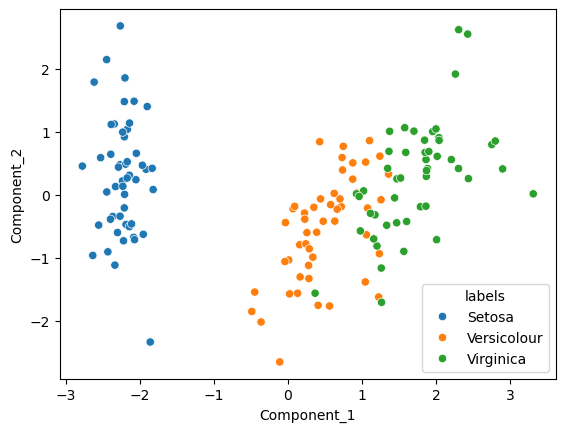

In [138]:
def plot_pca(X, labels, ax=None):
    pca_projected = pd.DataFrame(X, columns=['Component_1','Component_2'])
    pca_projected['labels'] = labels 
    if ax == None: 
        sns.scatterplot(data=pca_projected, x='Component_1', y='Component_2', hue='labels')
    else:       
        sns.scatterplot(data=pca_projected, x='Component_1', y='Component_2', hue='labels', ax=ax)
    return pca_projected
  
# Instantiate a PCA model object with 2 components
pca_model = PCA(n_components=2)

# Fit the model to the iris data and transform it
iris_pca = pca_model.fit_transform(iris_data)

# Use the species labels from the iris dataset
species = iris['species']

## Plot and save the results 
pca_projected = plot_pca(iris_pca, species)

> Examine the plot you have created. Answer the following questions:  
> 1. How well can these clusters be linearly separated and thereby separating the specie classes and why?  
> 2. Notice the different scales of the two projected variables. Is the range of values of the components consistent with the variance of the components?    


> **Answers:**       
> 1.   The first two principal components result in three distinct clusters corresponding to the three species of iris flowers. Setosa seem to be well separated cluster and the other two are slightly intertwining.

> The ability to linearly separate the clusters is due to the variance captured by the first two principal components. The first principal component (PC1) captures the most variance, followed by the second principal component (PC2). These components effectively project the high-dimensional data into a 2D space where the main structure and variance between the species are preserved.

> 2.   The scales of the two components ("PC1" and "PC2") in the plot are different. Typically, PC1 has a larger range of values compared to PC2. This difference in scale is consistent with the variance explained by the components as seen earlier. PC1 explains the most variance, which results in a wider spread of values. 

> We can check the independence of the components by computing the covariance. In the cell below create and execute code to . to display the covariance of the projected components. 

In [139]:
# Compute the covariance matrix of the projected components
covariance_matrix = np.cov(iris_pca, rowvar=False)
covariance_matrix

array([[ 2.93808505e+00, -6.67624047e-16],
       [-6.67624047e-16,  9.20164904e-01]])

> 3. Notice the small values of the off-diagonal components. Do these values indicate the components are orthogonal.
> **End of Exercise.**

> **Answer 3:** Yes they do. In PCA, orthogonality of the principal components means that they are uncorrelated. The off-diagonal elements are very close to zero, indicating that the components are uncorrelated and therefore orthogonal. The principal components should capture the maximum variance in the data while being uncorrelated (orthogonal) to each other.

## Second Example Dataset

The bowl disease gene dataset has high dimensionality, with over 10,000 features. The question is, can this high dimensional space be projected to a lower dimensional space?   

Execute the code in the cell below to load the data set and prepare it for analysis. 

In [140]:
gene_data = pd.read_csv('ColonDiseaseGeneData-Cleaned.csv')
labels = gene_data.loc[:,'Disease State']
gene_data = gene_data.drop('Disease State', axis=1)

## Normalize the columns 
gene_data = (gene_data - gene_data.mean(axis=0)) / gene_data.std(axis=0)

## Display the results 
print('Shape of the data array = ' + str(gene_data.shape))
print(gene_data.head())

Shape of the data array = (97, 10497)
    FAM138F  LOC100133331  LOC100132062  LOC388312  BC016143  BC071797  \
0  0.037249     -0.291076     -0.468366  -0.565637 -1.205652  0.986297   
1  2.703451     -0.857027     -0.466911  -0.248338 -0.872731 -0.190712   
2 -1.514233      0.406056      0.401003   0.519990 -0.492251  0.996789   
3  1.247350     -1.311608     -1.493856  -1.296212  0.197563 -0.534373   
4  0.223893     -0.621705     -0.707016  -0.745680 -0.853011 -0.022725   

   AX746564  LINC00623    FAM45B      DUX4  ...     TTLL3     TTLL4     TTLL5  \
0 -0.503054   0.635754  0.591468  0.050201  ...  0.121856 -0.505228  0.590142   
1 -0.424813   0.144463 -0.198031  1.106732  ... -0.011350 -0.965304 -0.104514   
2  0.013537   0.606253  1.070210 -0.337467  ... -0.268654  0.943829  1.969924   
3  0.400227  -2.105780  2.243384  1.886012  ...  0.833996  0.451874 -0.653959   
4 -1.805564  -0.575825 -1.120419 -0.927462  ...  0.041022  0.705459 -0.277757   

      TTLL6     TTLL7     TTLL

For the 97 subjects there are gene expression values for over 10,000 genes. The limited number of sanples and extreme high dimensionality markes this a challenging problem.     

To get a feel for these data, execute the code in the cell below to create and display a UMAP embedding of the gene data.  

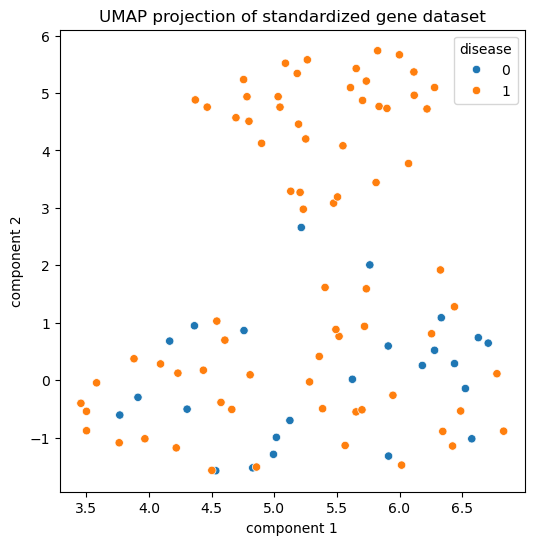

In [141]:
np.random.seed(4365)
gene_embedding = umap.UMAP().fit_transform(gene_data)

gene_embedding_df = pd.DataFrame(gene_embedding, columns = ['component1', 'component2'])
gene_embedding_df['disease'] = [0 if label=='Ulcerative Colitis (UC)' else 1 for label in labels]  

fig,ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=gene_embedding_df, x='component1', y='component2', hue='disease', ax=ax);
ax.set_xlabel('component 1');
ax.set_ylabel('component 2');
ax.set_title('UMAP projection of standardized gene dataset');

On the plot, the disaese state is coded as 1 for Crohn's Disease and 0 for Ulcerative Colitis. By examining the plot is apparent that there is one grouping of patients with Crohn's Disease that is isolated from the others. There is another grouping where patients with both conditions appear mixed. These observations confirm that separating this second group by disease is likely to be quite challenging.  

## PCA with Gene Data    

> **Exercise 08-4:** You will now explore the ability of PCA to reduce the dimensionality of the genetics data. To test this idea do the following:   
> 1. Instantiate a PCA object and apply the `fit` method with the `gene_data` as the argument.  
> 2. Print the cumulative sum of the variance explained by applying the [numpy.cumsum](https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html) function to the `explained_variance_ratio_` attribute of the model object. 
> 2. Plot the first 60 components of the `explained_variance_ratio_` attribute of the model object vs. the component number. 
> 3. Execute your code. 

The cumulative variance explained by the first 39 componenets = 0.8375106545855914
The full cumulative sums of the variance components:
[0.19744729 0.30715637 0.40512924 0.47612652 0.51618141 0.54888216
 0.57457227 0.59730935 0.61784554 0.63514969 0.65102267 0.6645669
 0.67668888 0.68870231 0.6995324  0.7093417  0.71797902 0.72592963
 0.73314569 0.74023849 0.74689214 0.75339877 0.75956477 0.76541687
 0.77109478 0.7766969  0.78216118 0.78736369 0.79244852 0.79737814
 0.80223947 0.80697126 0.81155868 0.81608333 0.820582   0.82491358
 0.82917238 0.83339176 0.83751065 0.84153554 0.84553019 0.84949856
 0.85338464 0.85717575 0.86093119 0.86462334 0.86824973 0.87179689
 0.87531155 0.87878244 0.88217903 0.88553752 0.88884348 0.89213425
 0.89537022 0.89855472 0.9017166  0.90483473 0.90792369 0.91098216
 0.91401584 0.91699746 0.91995369 0.92289479 0.92579413 0.92866494
 0.93151476 0.93435316 0.93715958 0.93991837 0.94266916 0.94538831
 0.94807197 0.95068357 0.95325638 0.95581581 0.95836068 0.960

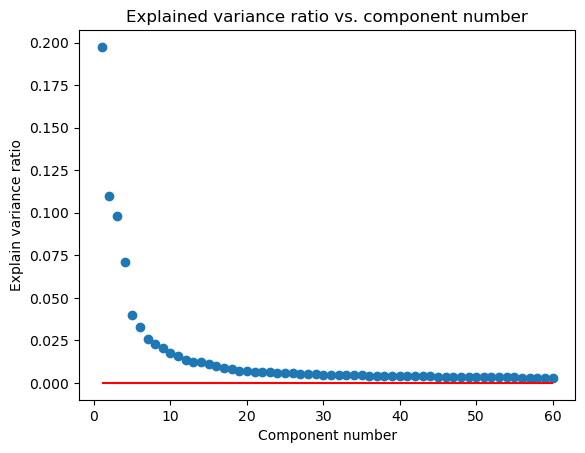

In [142]:
# Instantiate a PCA object
gene_pca = PCA()

# Apply the fit method to the gene data
gene_pca.fit(gene_data)

# Cumulative sum of the variance explained
cumsums = np.cumsum(gene_pca.explained_variance_ratio_)

print('The cumulative variance explained by the first 39 componenets = ' + str(cumsums[38]))
print('The full cumulative sums of the variance components:')
print(cumsums)

## Display the explained variance ratio vs. component 
n_components = 60
_=plt.scatter(range(1, n_components + 1), gene_pca.explained_variance_ratio_[:n_components])    
_=plt.hlines(0,1,n_components, color='red')
_=plt.xlabel('Component number')
_=plt.ylabel('Explain variance ratio')
_=plt.title('Explained variance ratio vs. component number')

> Study your plot. Notice that the explained variance ratio decreases rapidly with the component number. Answer the following questions:  
> 1. From the cumulative sums of the variance explained, approximately how much of the total variance can be explained by the first 39 components?  
> 2. Does the decay of the variance explained curve indicate that significant dimensionality reduction is possible for these data?   

> **Answers:**    
> 1. Looking at the graph, likely 95% or higher.      
> 2. Yes, if the first 40 components explain 95% of the variance, one can reduce the dimensionality from a high number of features to 40 principal components without losing much information.     

> Now you will display and examine a pairwise scatter plot of the first components of the PCA decomposition of the genetics data. Execute the code below with the number of components representing a cumulative 60% of the variance.    

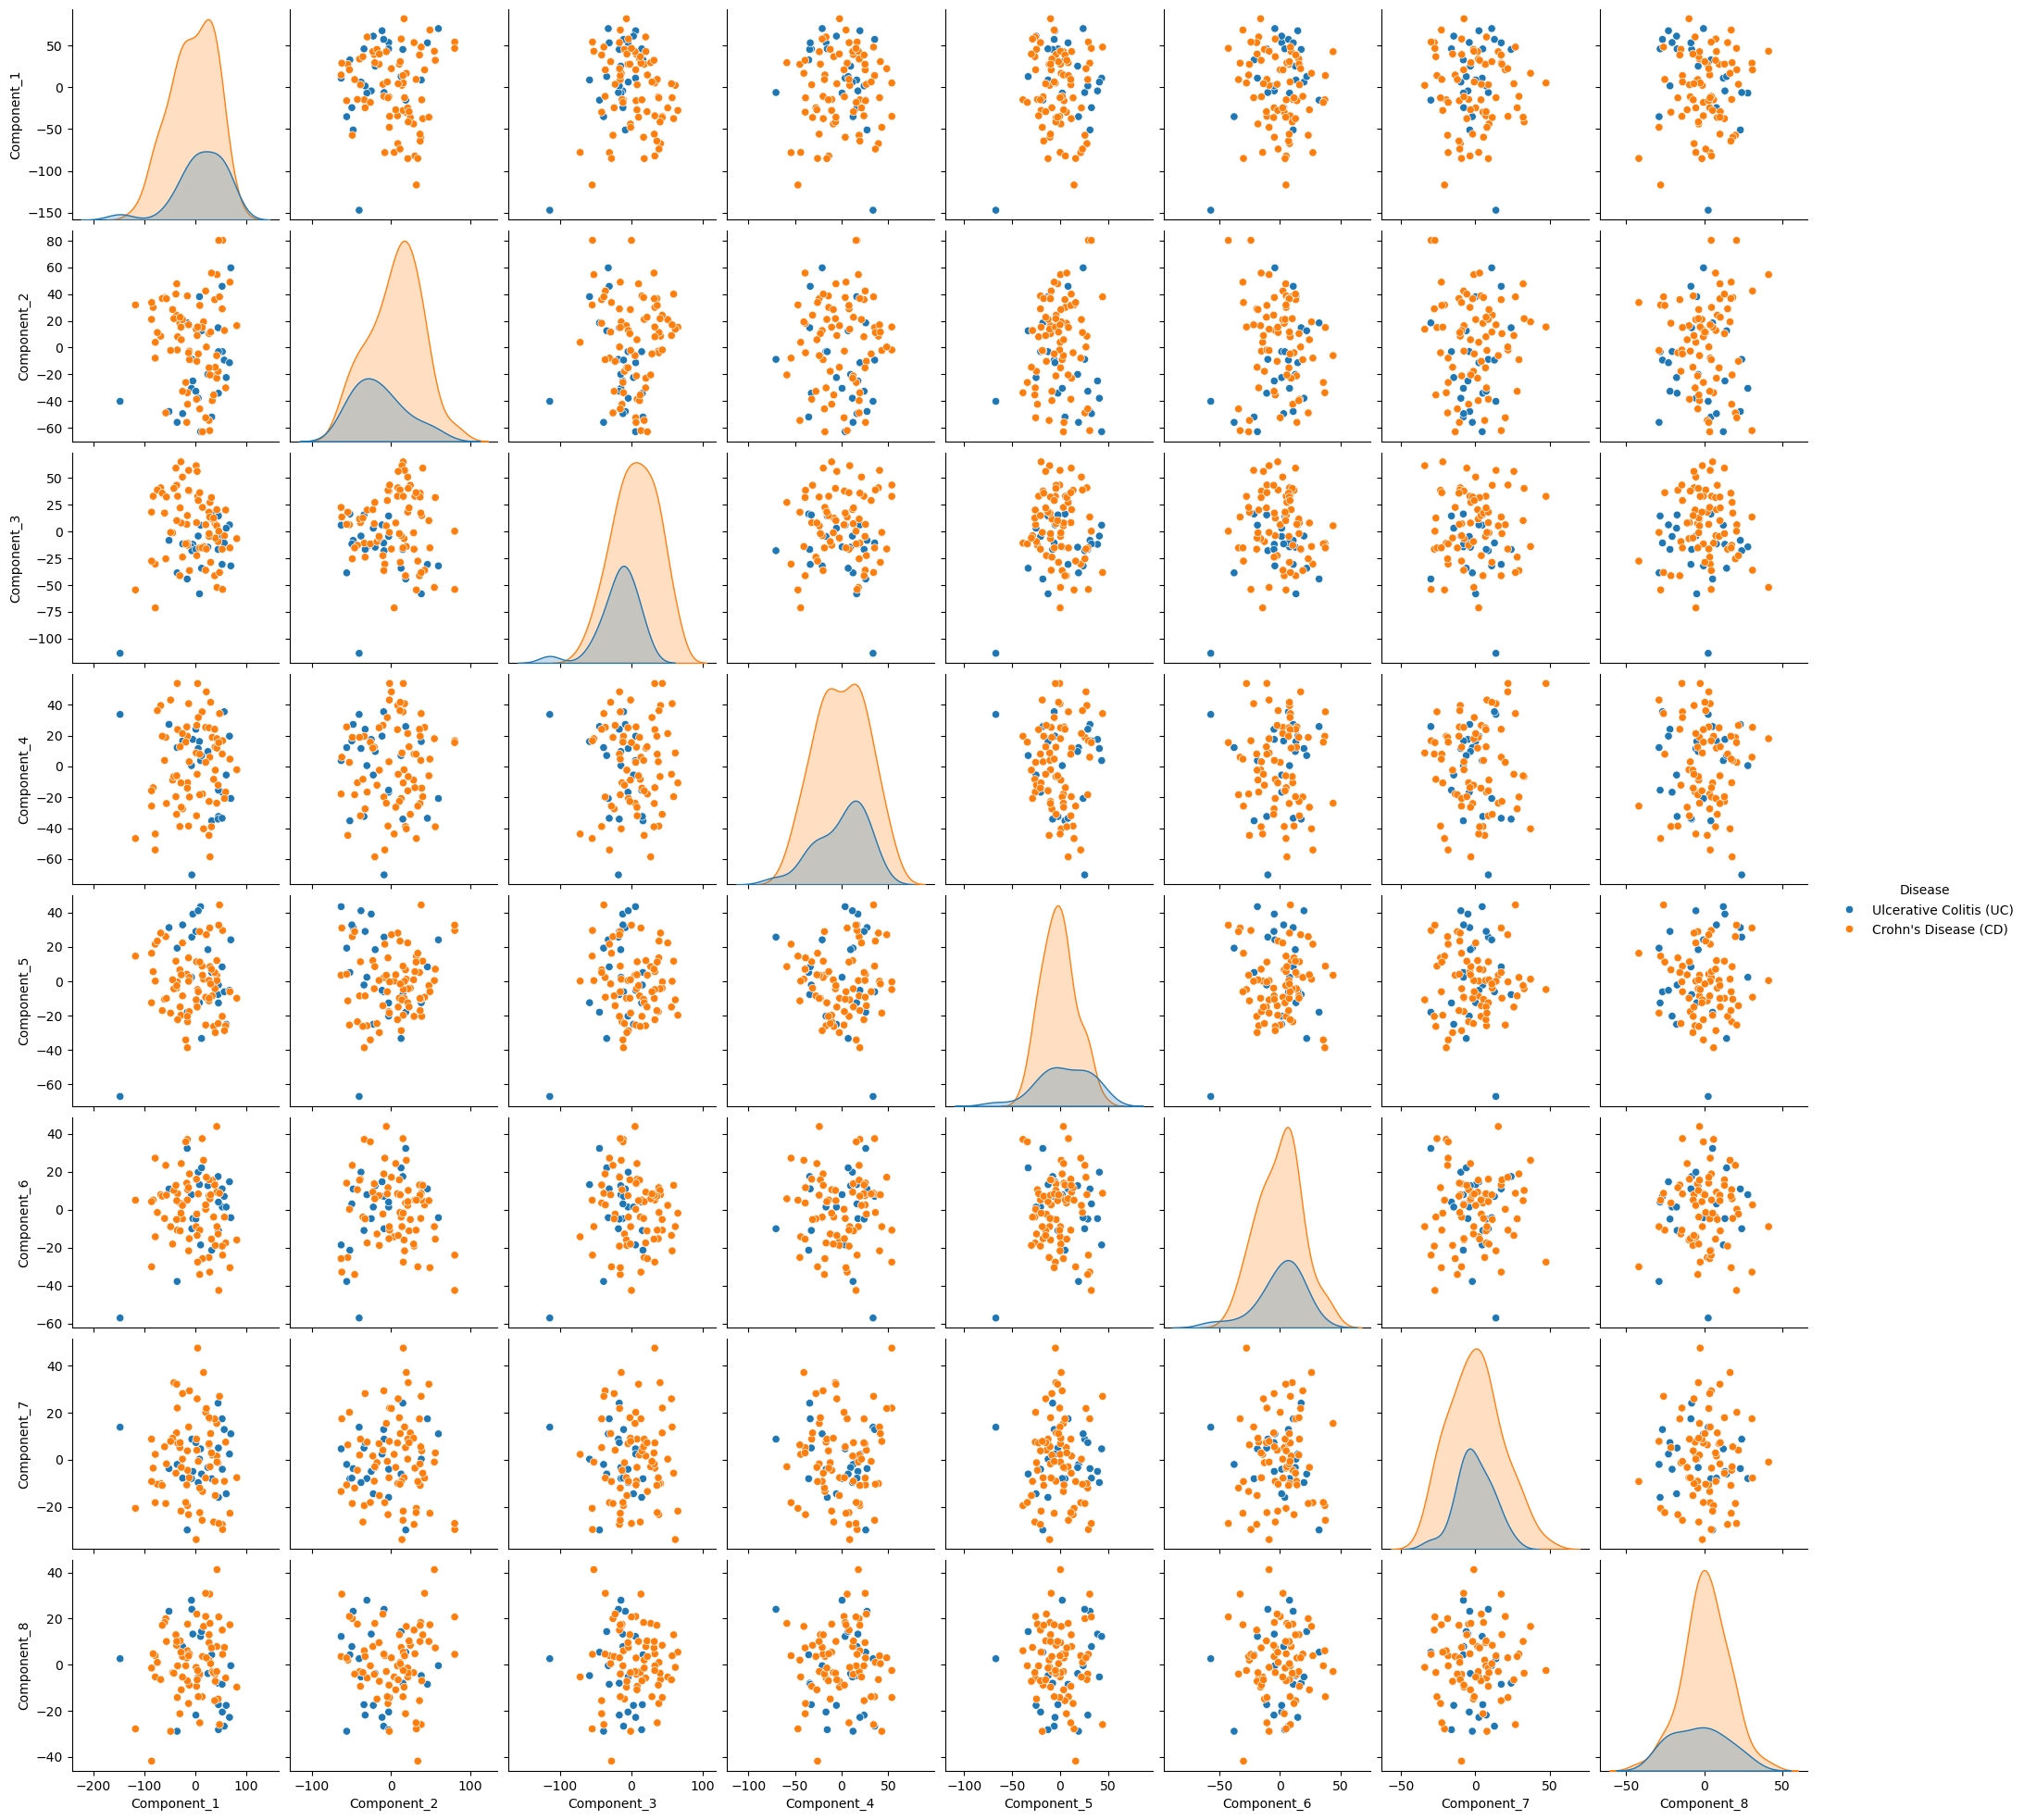

In [143]:
## Display the components
n_components = 8 
gene_components = ['Component_1','Component_2','Component_3','Component_4','Component_5','Component_6','Component_7','Component_8']
gene_pca_8 = PCA(n_components=n_components).fit(gene_data)
gene_pca_projected = pd.DataFrame(gene_pca_8.transform(gene_data), columns=gene_components)
gene_pca_projected['Disease'] = labels
_=sns.pairplot(gene_pca_projected, hue='Disease')

> Examine the plot. Notice that most of the component values of the two disease types have significant overlap. However, in some cases there are differences in the values on the scatter plots and the marginal density plots. What do these relationship indicate about the ability of these components to separation of the two disease conditions?      
> **End of exercise.**  

> **Answer 3:** 

> The significant overlap between the two disease states in most components suggests that PCA alone, using only the first eight components, may not be sufficient to achieve a clear separation between UC and CD. The presence of some differences in specific component combinations implies that there are underlying patterns in the data that PCA captures, but these patterns are not strong enough to achieve distinct separation. The overlap indicates that the disease states might be more complex and possibly require non-linear methods or additional data processing to improve separation.   

### K-means with PCA    

The projection of gene data features onto the orthogonal PCA space, can help with creating a better cluster model. In this case, we will create a k-means cluster model using the first 39 components.     

As a first step, we need to determine how many clusters there should be. To do so, execute the code in the cell below and examine the resulting plots.  

/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


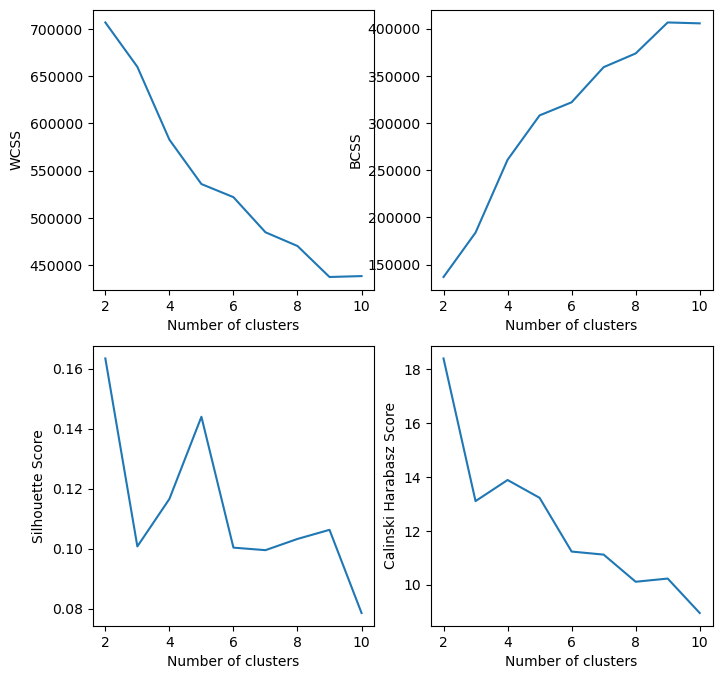

In [144]:
def cluster_search_kmeans(df, nclusts=(2,21)):
    ## If there are cluster assignments in the data frame remove them. 
    if 'cluster_assignments' in df.columns: df.drop(columns='cluster_assignments', inplace=True)
    WCSS=[]
    BCSS=[]
    silhouette=[]
    CH_index = []
    ## Compute total sum of squares
    x_bar = np.mean(df, axis=0)
    TSS = np.sum(np.sum(np.square(df - x_bar)))
    for n in range(nclusts[0],nclusts[1]+1):   
        temp_model = KMeans(n_clusters=n).fit(df) 
        WCSS.append(temp_model.inertia_)
        BCSS.append(TSS - temp_model.inertia_)
        assignments = temp_model.predict(df)
        silhouette.append(silhouette_score(df, assignments))
        CH_index.append(calinski_harabasz_score(df, assignments))
    _, ax = plt.subplots(2,2, figsize=(8,8))    
    ax = ax.flatten()
    ax[0].plot(range(nclusts[0],nclusts[1]+1),WCSS)   
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('WCSS')
    ax[1].plot(range(nclusts[0],nclusts[1]+1),BCSS)   
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('BCSS')
    ax[2].plot(range(nclusts[0],nclusts[1]+1),silhouette)   
    ax[2].set_xlabel('Number of clusters')
    ax[2].set_ylabel('Silhouette Score')
    ax[3].plot(range(nclusts[0],nclusts[1]+1),CH_index)   
    ax[3].set_xlabel('Number of clusters')
    ax[3].set_ylabel('Calinski Harabasz Score')
     
    
n_components = 39   
gene_pca_transform = gene_pca.transform(gene_data)
gene_pca_transform = pd.DataFrame(gene_pca_transform[:,:n_components], columns=[str(i) for i in range(n_components)])
    
np.random.seed(9686)
cluster_search_kmeans(gene_pca_transform, nclusts=(2,10)) #, label_column='Disease')    

The question now is, how to interpret these plots. There is no clear 'peak' in the Calinski-Harabasz index, except at 2 clusters. 2 clusters just represnts the grouping of the values already observed, and is not particularly interesting. The peak at 4 clusters in the silhouette coefficient plot is more promising. Additionally, there are small, but noticable, breaks in the curves of the Calinski-Harabasz index, WCSS and BCSS at 4 clusters. We will go with 4 clusters. To creste and evaluate the 4-cluster model, execute the code in the cell below.    

cluster_assignments  disease
0                    0           6
                     1          15
1                    0          14
                     1          23
2                    0           4
                     1           8
3                    1          27
Name: count, dtype: int64

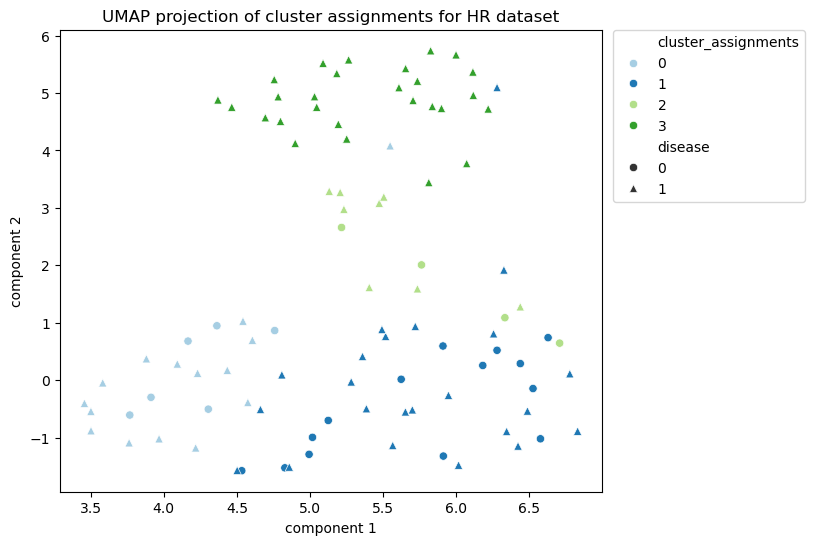

In [145]:
def plot_cluster_assignments(df):    
    fig,ax = plt.subplots(figsize=(7,6))
    sns.scatterplot(data=df, x='component1', y='component2', 
                    hue='cluster_assignments', style='disease', 
                    markers=['o','^'], palette="Paired", ax=ax) 
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.set_xlabel('component 1');
    ax.set_ylabel('component 2');
    ax.set_title('UMAP projection of cluster assignments for HR dataset');

n_clustsers=4
n_components=60   
if 'labels' in gene_pca_transform.columns: gene_pca_transform.drop('labels', axis=1, inplace=True)
gene_embedding_df['cluster_assignments'] = KMeans(n_clusters=n_clustsers).fit_predict(gene_pca_transform)

plot_cluster_assignments(gene_embedding_df)

gene_embedding_df.loc[:,['cluster_assignments','disease']].value_counts().sort_index()

This model shows some interesting relationships. One cluster has only cases with Corhn's disease, and another near by cluster has predomenently cases of this same condition. The other two clusters are mixed between the two diseases. These clusters separate these mixed cases into two identifiable groups, which may be of some value to scientists. It is likely that considerable domain knowledge is required to go further with the interpretation of this model. 

## Kernel PCA

Kernel PCA uses a nonlinear mapping between nonlinear sample space and a lower dimensional linear space. The mapping is created by the linear superposition of nonlinear kernel functions. The result is a nonlinear mapping to a lower dimensional embedding space.       

You will now apply the nonlinear kernel PCA method to the iris dataset by the following steps:   
1. Instantiate a [kernel PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html) object with the `kernel='cosine` argument. 
2. Use the `fit` method with the 'iris_data' as the argument.   
3. Plot the singular values, the `eigenvalues_` attribute of the model object, vs. the component number.        

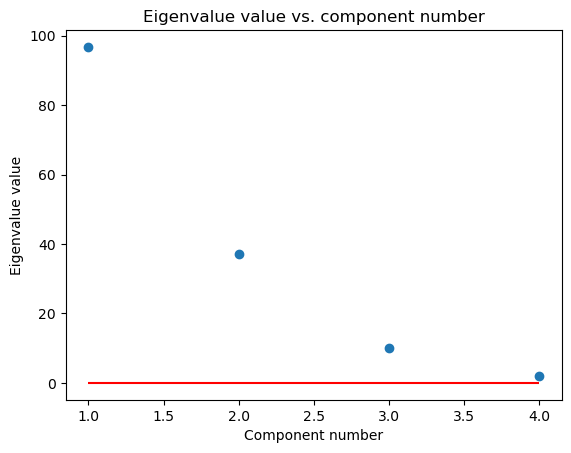

In [146]:
iris_kernel_pca = KernelPCA(kernel='cosine')
iris_kernel_pca.fit(iris_data)

## Display the variance ratio explained vs. component 
n_components = 4
_=plt.scatter(range(1, len(iris_kernel_pca.eigenvalues_) + 1), iris_kernel_pca.eigenvalues_)
_=plt.hlines(0,1,len(iris_kernel_pca.eigenvalues_), color='red')
_=plt.xlabel('Component number')
_=plt.ylabel('Eigenvalue value')
_=plt.title('Eigenvalue value vs. component number')

Examine the plot of the eigenvalues. Eigenvalues 3 and 4 are essentially the same and small, indicating there are only 2 significant dimensions of this projection.  


Now you will create and plot the results of a kernel PCA decomposition of the iris data by the following steps:  
1. Instantiate a [sklearn.decomposition.KernelPCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html) object with arguments `n_components=2` and `kernel='cosine'`.  
2. Use the `fit_transform` method with the iris data as the argument to compute the projection into the new space. 
3. Display a plot of the two components using the `plot_pca` function. 

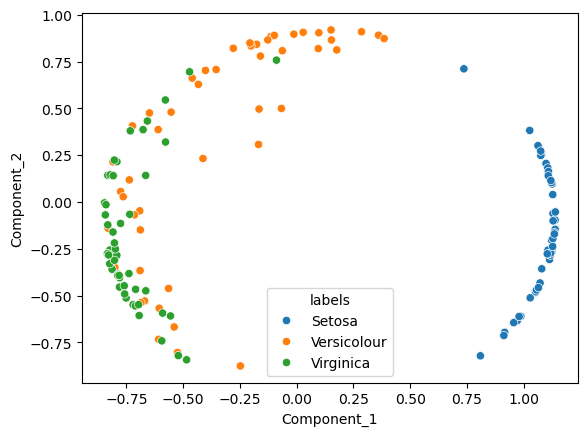

In [147]:
iris_kernel_pca = KernelPCA(n_components=2, kernel='cosine').fit_transform(iris_data)
pca_projected=plot_pca(iris_kernel_pca, species)

Examine the plot and notice that these clusters of cannot be linearly separated since there is considerable overlap.        

> **Exercise 08-5:** Changing the kernel can have a significant impact on the projected components of the kernel PCA model. To see an example, repeat the steps used in the previous exercise, but the the argument `kernel='rbf'`, the radial basis function.

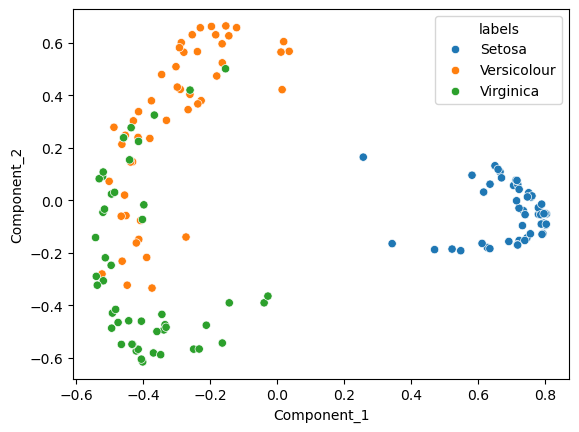

In [148]:
iris_kernel_pca = KernelPCA(n_components=2, kernel='rbf').fit_transform(iris_data)
pca_projected=plot_pca(iris_kernel_pca, species)

> These results are quite different from the cosine kernel projection. Which kernel do you think gives a more useful projection of the iris data with respect to linearly separating the classes?   
> **End of exercise.**

> **Answer:**  The RBF kernel is likely to provide a more useful projection for the iris data in terms of separating the classes. This is because it can capture and project non-linear relationships, leading to better clustering and separation of the different species. The cosine kernel should be better for data where the similarity of directions is more meaningful than magnitudes.

### Kernel PCA in high dimensions

Next, we will try kernel PCA on the gene dataset. Here, we will try the `cosine` metric. Execute the code in the cell below and examine the results. 

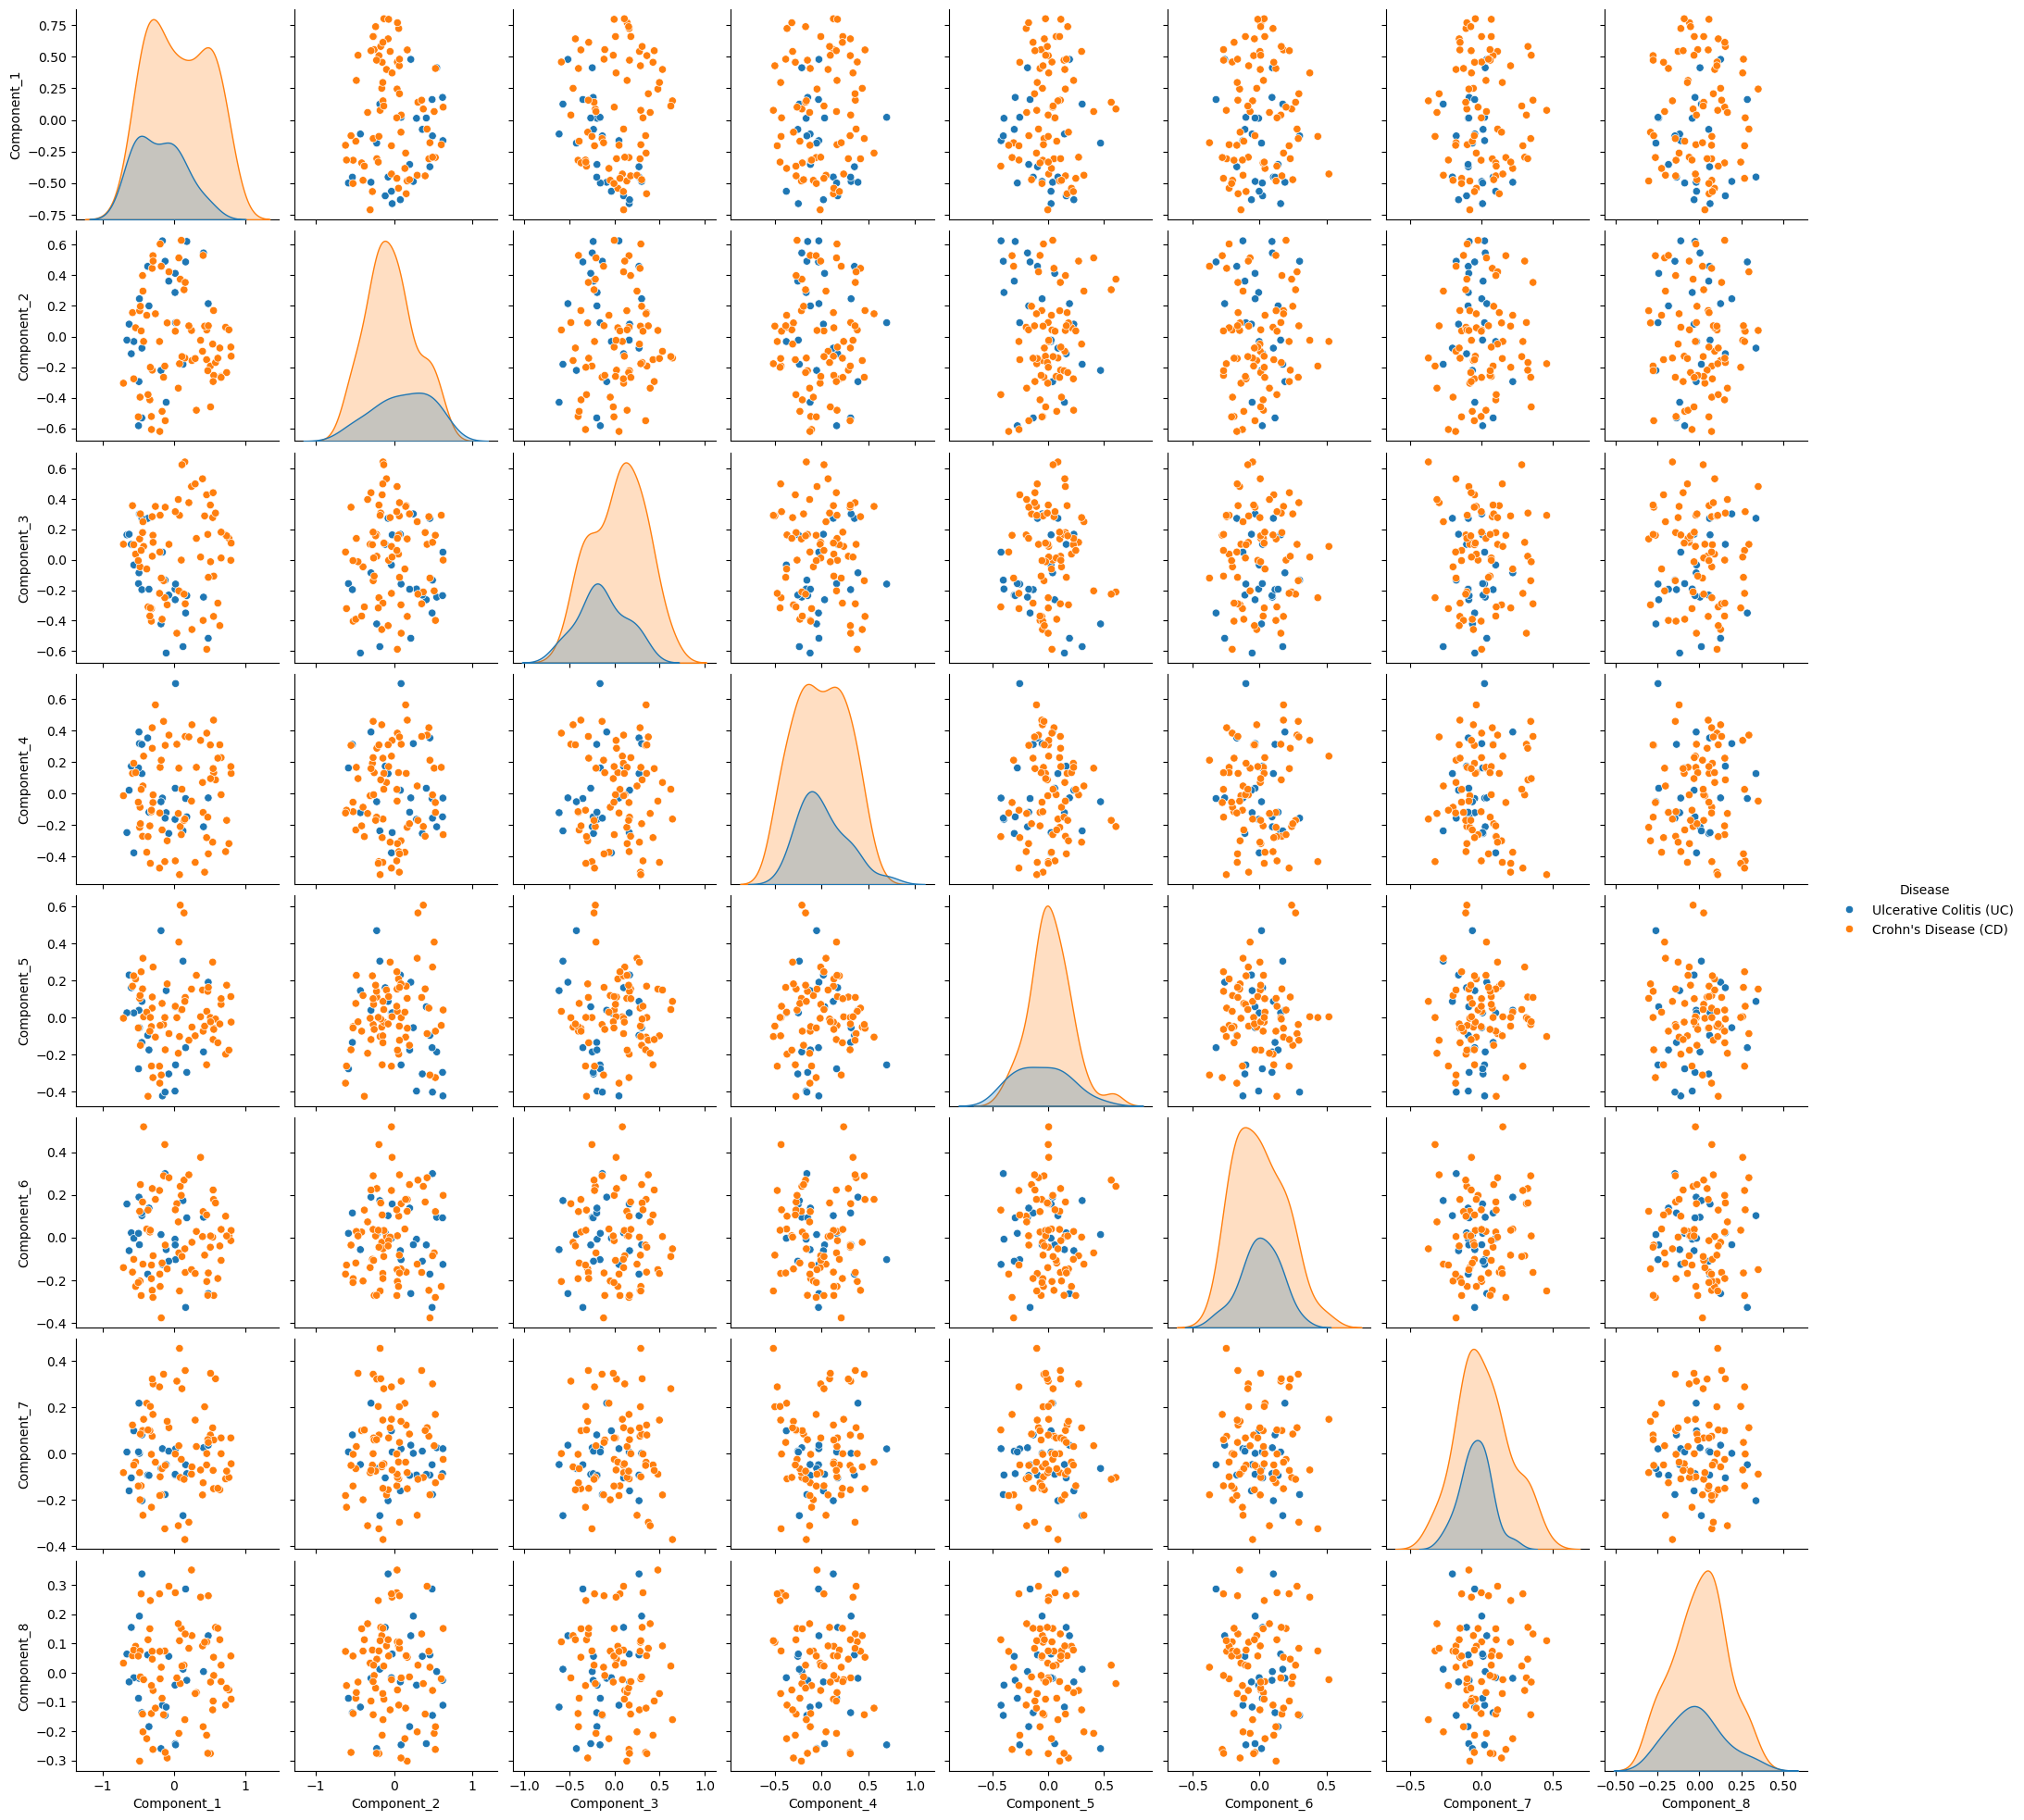

In [149]:
n_componenents=30
n_display_componenets=8
gene_kernel_pca = KernelPCA(n_components=n_componenents, kernel='cosine').fit_transform(gene_data) #, kernel='sigmoid').fit_transform(gene_data)
gene_pca_kernel_8 = pd.DataFrame(gene_kernel_pca[:,:n_display_componenets], columns=gene_components)
gene_pca_kernel_8['Disease'] = labels 
_=sns.pairplot(gene_pca_kernel_8, hue='Disease')

Compare this plot to the one created with linear PCA. Overall, these results seem nearly identical. It may be the case that a nonlinear transformation is not required for these data.

## Random Projections with Gene Data

Given the high dimensionality of the data it will be interesting to apply the [random projection dimensionallity reduction algorithm](https://en.wikipedia.org/wiki/Random_projection). This algorithm applies probabilistic sampling to very high dimensional spaces to find a lower dimensional, distance preserving, embedding. The error, $eps$ can be calculated from the [Johnson-Lindenstrauss lemma](https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma). As a result, lower bound on the dimensions of the embedding space, given the number of samples, can be computed as:    

$$minum\ dimension = \frac{4\ log(number\ samples)}{eps^2/2 - eps^3/3}$$

You can use this relationship to create a table to determine the appropriate dimensionallity reduction for a given sample size. 

> **Exercise 08-06:** Using the above relationship compelete the lambda (annonomous function) in the code cell below.    

In [150]:
n_samples = 97
eps = [0.05, 0.1, 0.15, 0.2, 0.3, 0.5]

## Completed the lambda function below
min_components = lambda eps: np.ceil(4 * np.log(n_samples) / (eps**2 / 2 - eps**3 / 3))

pd.DataFrame({'eps':eps, 'Min_Components':[min_components(eps_i) for eps_i in eps]})

eps  Min_Components
0  0.05         15144.0
1  0.10          3922.0
2  0.15          1808.0
3  0.20          1056.0
4  0.30           509.0
5  0.50           220.0

> Continuing with the exercise, specify the missing arguments for the `random_projection.SparseRandomProjection` funciton in the code cell below. Use $eps=0.15$ and the number of samples rounded up to the nearest multiple of 1000.   

Dimensions of the transformed gene data = (97, 2000)


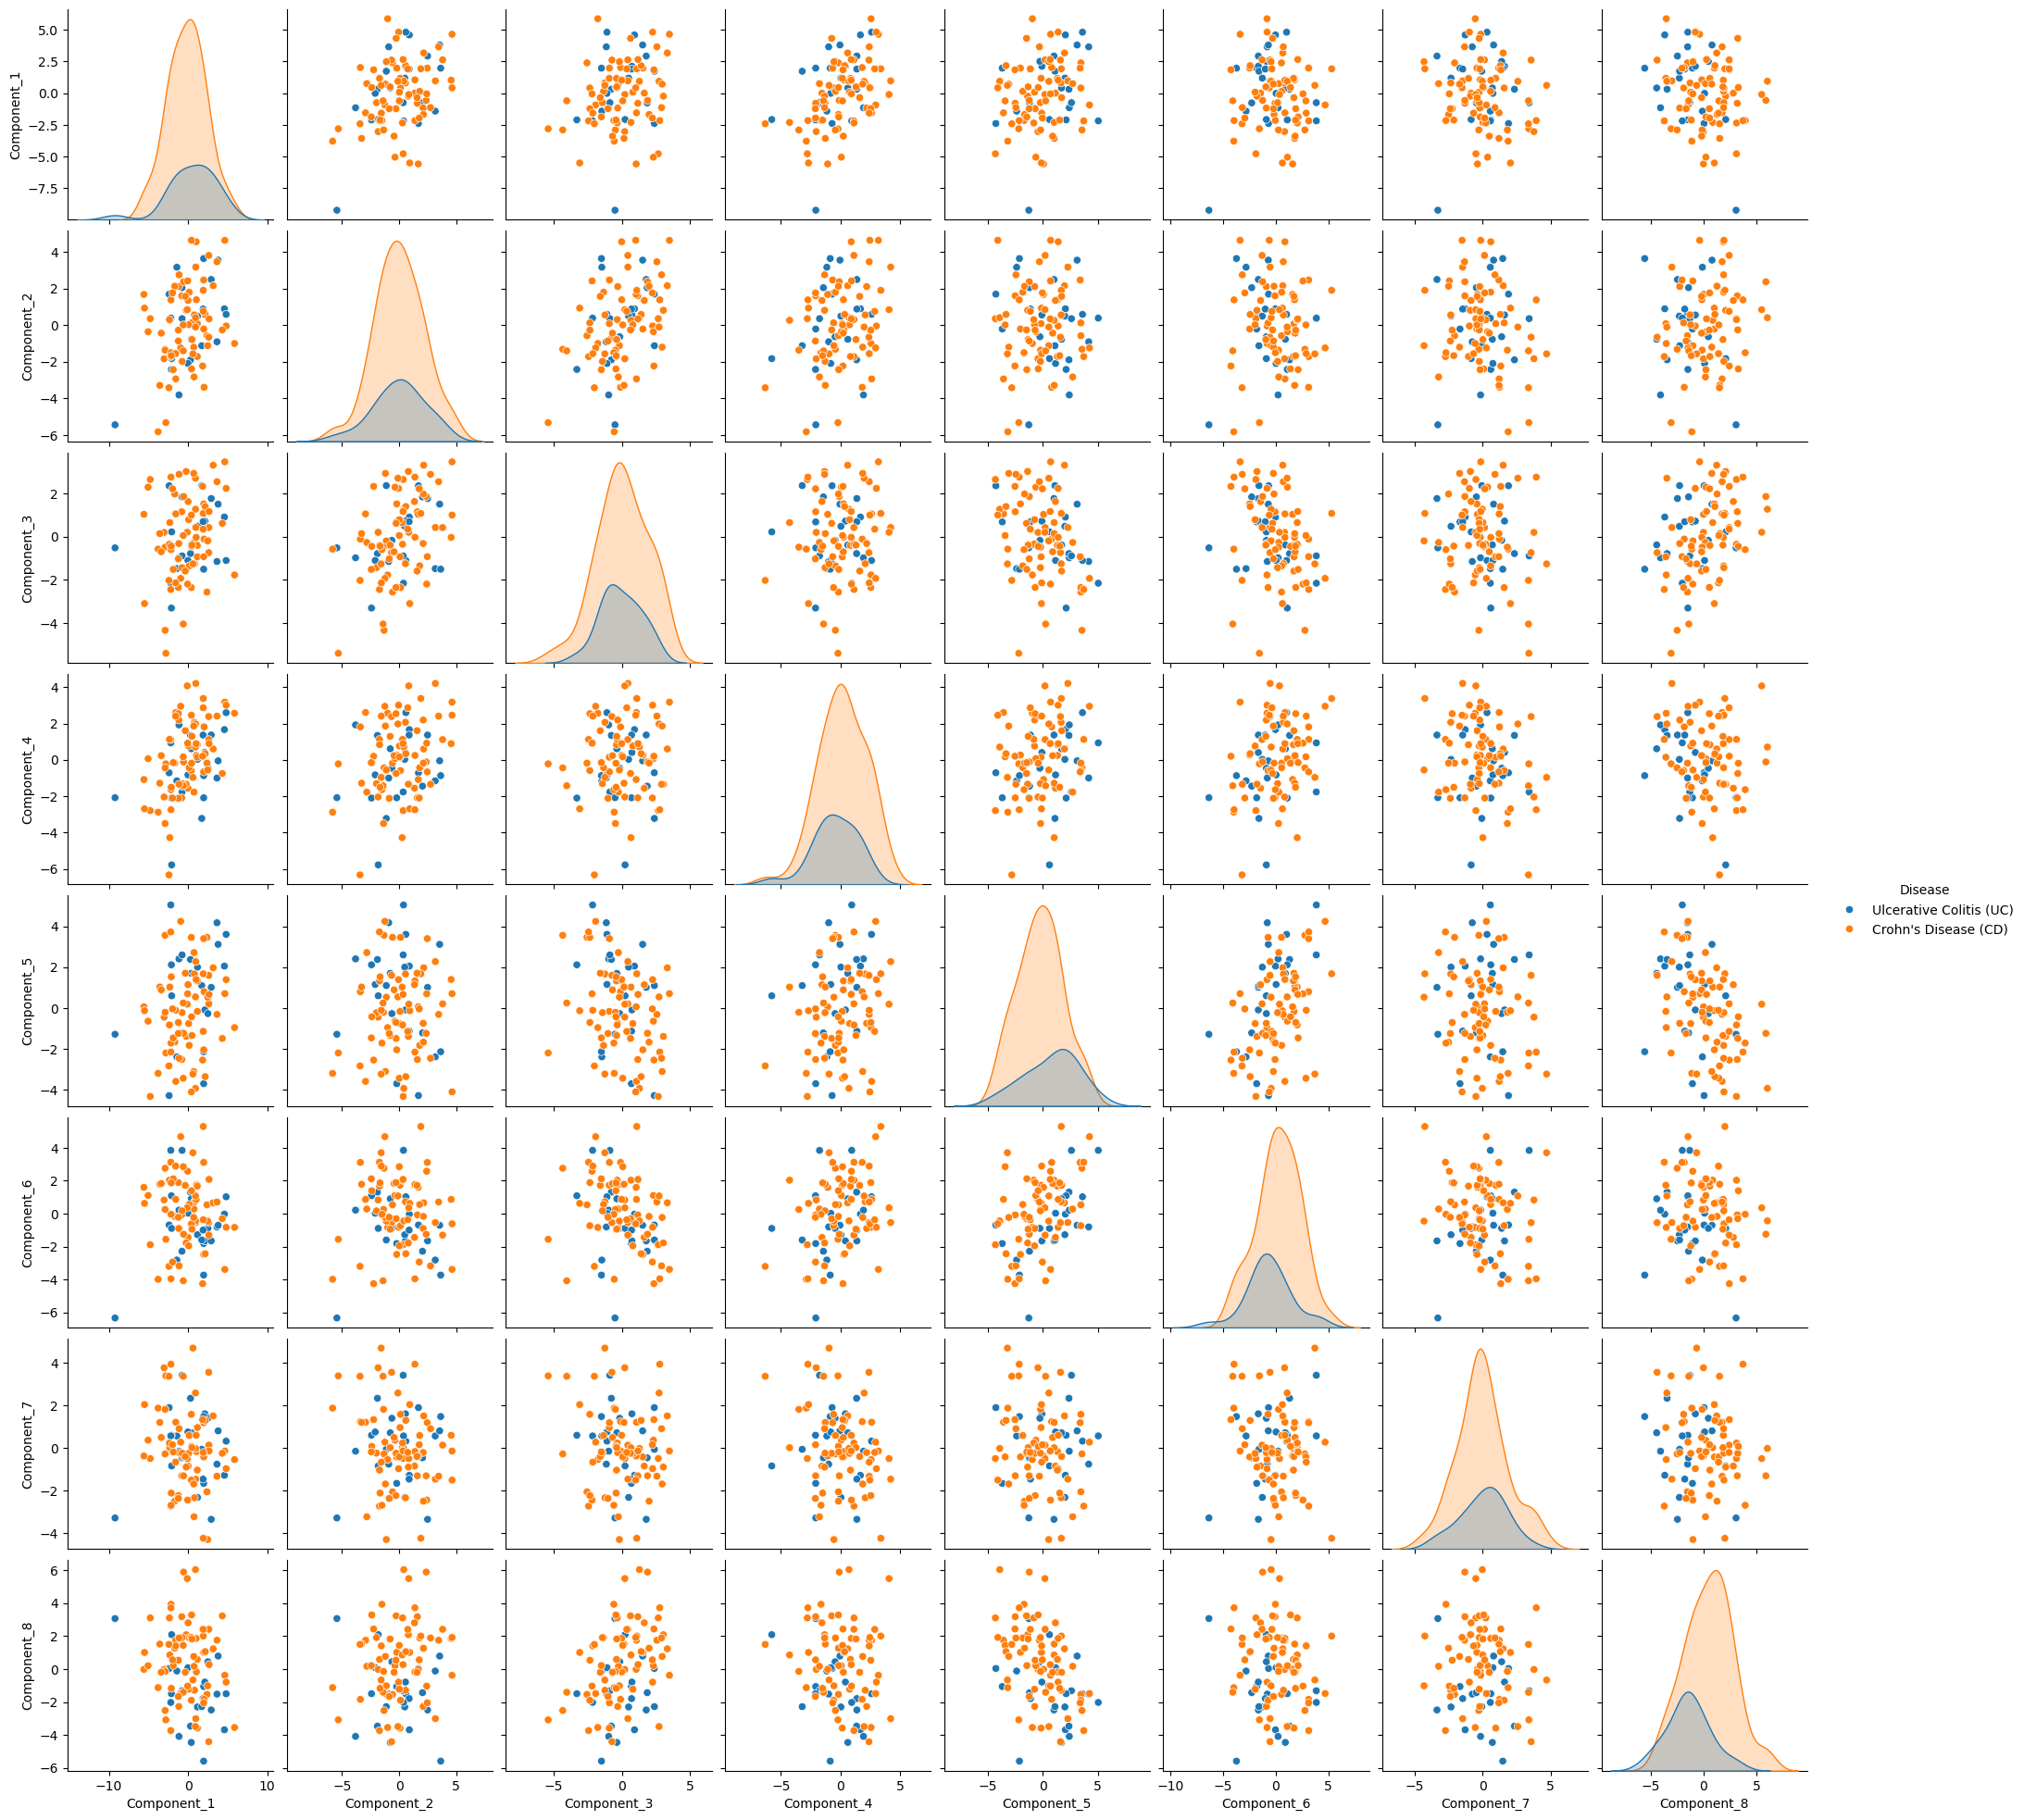

In [151]:
np.random.seed(5829)

## Specify the n_components arguemnt in the code below
n_componenets=2000
transformer = random_projection.SparseRandomProjection(n_components=n_componenets, eps=0.15)

## Plot the first 8 components 
X_gene_data = transformer.fit_transform(gene_data)
X_gene_data_temp =  pd.DataFrame(X_gene_data[:,:8], columns=gene_components)
X_gene_data_temp['Disease'] = labels
_=sns.pairplot(X_gene_data_temp, hue='Disease')
print('Dimensions of the transformed gene data = ' + str(X_gene_data.shape))

> Examine the pairs plot of the first 8 components of the embedding space displayed above. While there some components separate the two samples for the two diseases, there is considerable overlap in all dimensions.    
> **End of exercise.**

### K-means clustering with random projection   

The random projection has reduced the dimensionality of the gene data by about a factor of 5. The next question to address is, how does this reduction in dimensionality affect a clustering model. To find out you will now test k-means clustering on the random projection.   

Execute the code in the cell below to compute the k-means model for several values of k and to display the results.   

/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


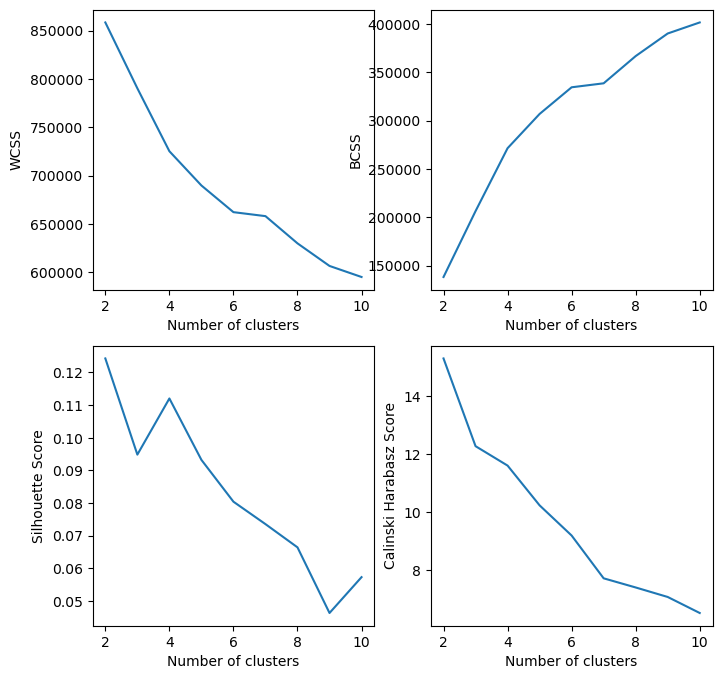

In [152]:
np.random.seed(996786)
cluster_search_kmeans(pd.DataFrame(X_gene_data), nclusts=(2,10))    

Once again the results of the k search are ambiguious. Further, these results appear to be nearly identical to those found with linear PCA dimensionality reduction.           

Execute the code in the cell below to display the k=4 clusters in the low-dimensional embedding space.   

cluster_assignments  disease
0                    0          18
                     1          33
1                    1          19
2                    0           6
                     1          11
3                    1          10
Name: count, dtype: int64

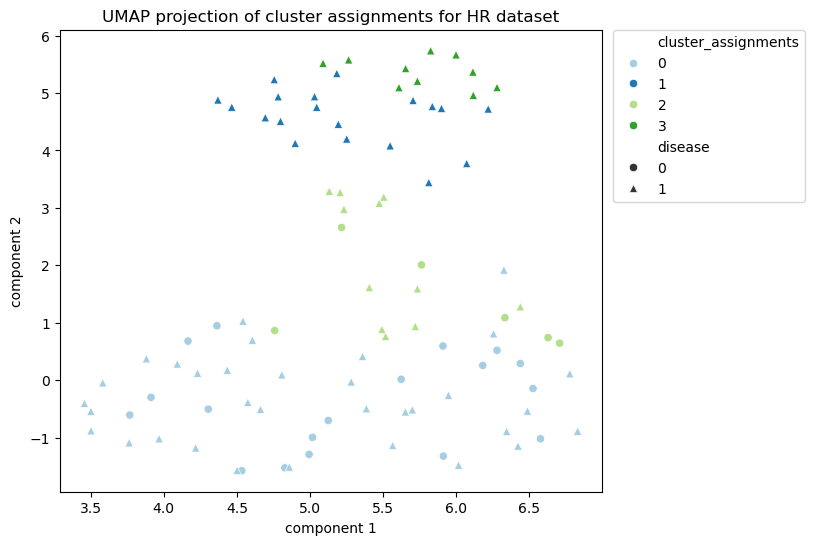

In [153]:
np.random.seed(654)
n_clusters=4
X_gene_data = pd.DataFrame(X_gene_data)
gene_embedding_df['cluster_assignments'] = KMeans(n_clusters=n_clusters).fit_predict(X_gene_data)

plot_cluster_assignments(gene_embedding_df)

gene_embedding_df.loc[:,['cluster_assignments','disease']].value_counts().sort_index()

Once again, the results are nearly identical to those obtained by clustering the linear PCA components.  

> **Exercise 08-07:** Examine the results displayed above and the results obtained with linear PCA componenets. Why is this outcome expected given the properties of the random projection method?           

> **Answer:**  Similar results were expected because both methods preserve the underlying structure and distances in the data.
Random projection effectively reduces dimensionality while maintaining the essential characteristics of the data.
The inherent groupings and patterns in the high-dimensional gene data are captured similarly by both PCA and random projections, leading to comparable cluster assignments.

## Manifold Learning  

Manifold learning seeks to map high-dimensional data onto a low-dimensional linear or nonlinear manifold. In this case we will map to a two dimensional manifold which can be displayed as a plot. 

The Scikit-Learn package contains a large number of linear and nonlinear [manifold learning algorithms](https://scikit-learn.org/stable/modules/manifold.html). Here we will only investiage two possibilities, spectral manifold learning and the [UMAP algorithm](https://umap-learn.readthedocs.io/en/latest/index.html).   

### Spectral Manifold Learning 

> **Exercise 08-8:** You will now apply the spectral manifold learning to the iris dataset by these steps:   
> 1. Instantiate a [sklearn.manifold.SpectralEmbedding](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.SpectralEmbedding.html#sklearn.manifold.SpectralEmbedding) object with argument `affinity='rbf'`.
> 2. Use the `fit_transform` method with the iris data as the argument. 
> 3. Display the result using the `plot_pca` function.  

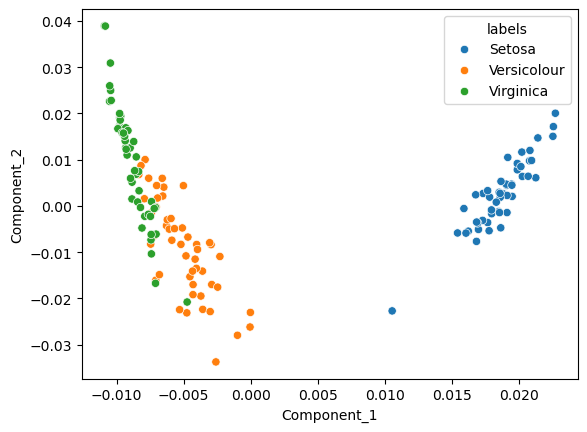

In [164]:
## Put your code below 
spectral_embedding = SpectralEmbedding(affinity='rbf')

iris_spectral = spectral_embedding.fit_transform(iris_data)

pca_projected=plot_pca(iris_spectral, species)

> Examine this plot. Which aspects of the data are well separated?  
> **End of exercise.**

> **Answer:**   Sentosa is well separated. Versicolor and virginica are not, but seem to be slightly better separated than results from prior methods.   

### UMAP      

You have been using the UMAP algorithm for visualization of clusters in this assignment and the previous one. You will now work with some properties of this Algorithm. As a starting point, execute the code in the cell below to display the embedding computed with the UMAP algorithm with default arguments. This plot will give you a baseline to compare affects of hyperparameters.    

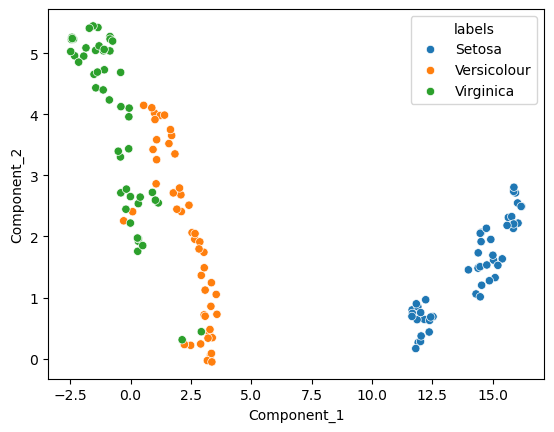

In [167]:
np.random.seed(8273)
iris_UMAP = umap.UMAP().fit_transform(iris_data)
umap_projected=plot_pca(iris_UMAP, species)

There are a number of key hyperparameters that affect the results produced by the UMAP algorithm. Here, we will focus on two, `n_neighbors` and `min_dist`. You can see additional examples of the effects of changing these hyperparamters in the [UMAP documentation](https://umap-learn.readthedocs.io/en/latest/parameters.html). 

The default values of the two parameters of interest here are, n_neighbors=15 and min_dist=0.1. The code in the cell below tests all possible pairs of hyperparameters that are 0.2 and 5.0 times the default values. The embedding for each hyperparameter pairs is then displayed. Execute this code and examine the result.      

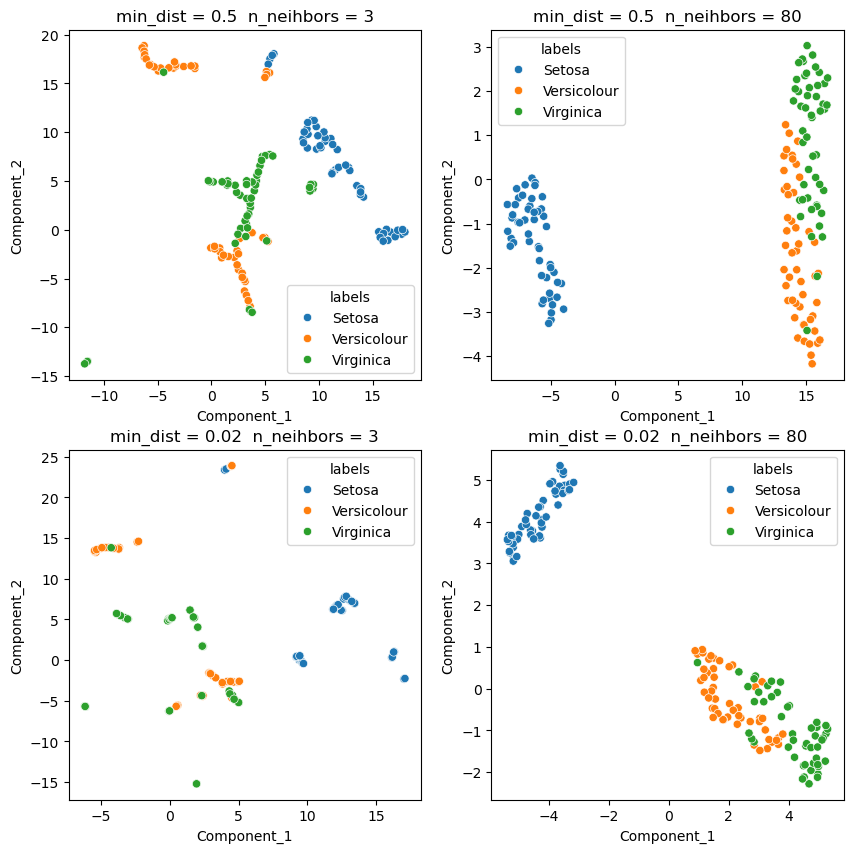

In [170]:
min_dist_list = [0.5, 0.5, 0.02, 0.02]
n_neighbor_list = [3, 80, 3, 80]
_, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.flatten()
np.random.seed(6655)
for i, (min_dist, n_neighbors) in enumerate(zip(min_dist_list,n_neighbor_list)):
    iris_UMAP = umap.UMAP(min_dist=min_dist, n_neighbors=n_neighbors).fit_transform(iris_data)
    umap_projected=plot_pca(iris_UMAP, species, ax=ax[i])
    ax[i].set_title('min_dist = ' + str(min_dist) + '  n_neihbors = ' + str(n_neighbors))

> **Exercise 08-9:** Examine these plots. Notice how the clusters change in the embedding. Now answer the following questions:     
> 1. How does changing the value of `n_neighbors` change the characteristics of the clusters shown in the embeddings plotted. Why is this behavior expected?          
> 2. How and for which plots does the display of the clusters on the embedding with different values of `min_dist`?  

> **Answers:**       
> 1. Higher n_neighbors: With higher values of n_neighbors, the clusters tend to become more compact and tightly grouped. This behavior is expected because increasing the number of neighbors used in the UMAP algorithm increases the local connectivity, leading to tighter clusters.      

> 2. When min_dist is set to a larger value (0.5), the clusters tend to be more separated and distinct from each other. This separation is achieved by forcing dissimilar points to be farther apart in the embedding space, which can help prevent clusters from merging. We see the effects of this in the n_neighbors = 80 plots, as when n_neighbors = 3 as per the left set of plots, the clusters are already too scattered to see this effect.

You can now examine the result of changing the hyperparameter values for the embedding of the gene data. As a first step, we execute the code in the cell below to display the baseline with the default hyperparameters.      

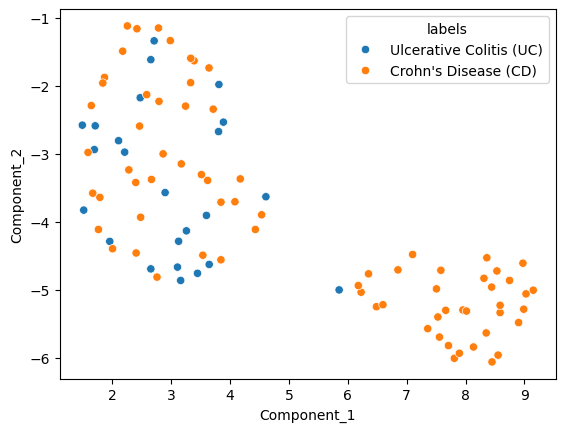

In [171]:
np.random.seed(8833)
gene_UMAP = umap.UMAP().fit_transform(gene_data)
umap_projected=plot_pca(gene_UMAP, labels)

Next, execute the code in the cell below to display the embeddings for the pairs of hyperparameter values.

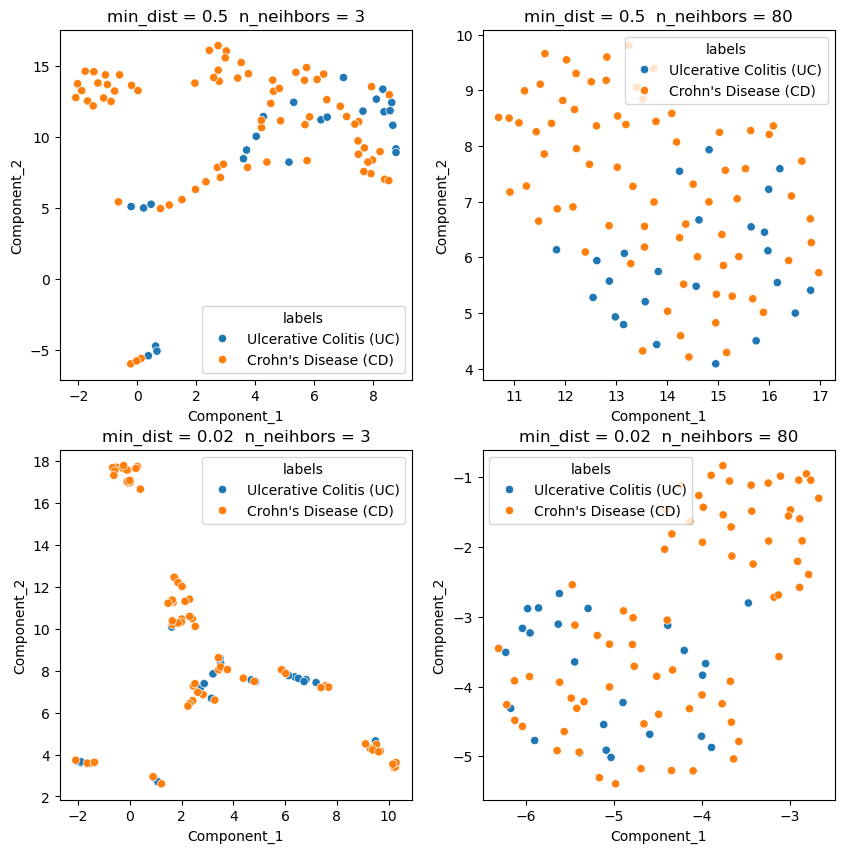

In [172]:
_, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.flatten()
np.random.seed(1010)
for i, (min_dist, n_neighbors) in enumerate(zip(min_dist_list,n_neighbor_list)):
    gene_UMAP = umap.UMAP(min_dist=min_dist, n_neighbors=n_neighbors).fit_transform(gene_data)
    umap_projected=plot_pca(gene_UMAP, labels, ax=ax[i])
    ax[i].set_title('min_dist = ' + str(min_dist) + '  n_neihbors = ' + str(n_neighbors))

Examine these plots and notice the following:      
1. The small value of `n_neighors` leads to fragmented clusters. Whereas, the large values of n_neighbors leads to large, poorly separated clusters. This represents the fact that the the `n_clusters` hyperparameter affects how local or wide the search for nearest neighbors is, which affects the properties of the graph used for the UMAP algorithm.      
2. For the small fragmented clusters created with the small value of `n_neighbors` the `min_dist` hyperparamter determines how separated the observations are.   

### t-SNE manifold learning 

We can now try the t-SNE manifold learning algorithm on the iris data. Execute the code in the cell below and examine the result.          

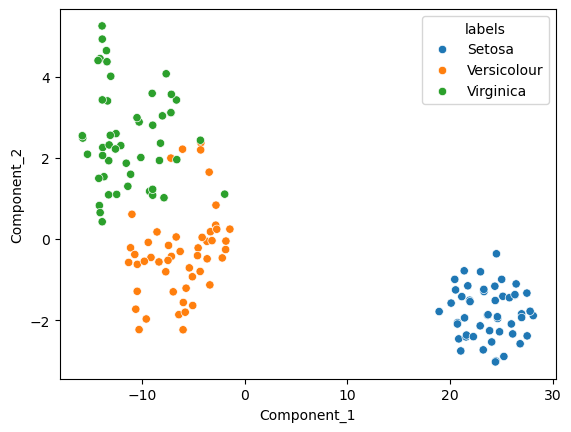

In [173]:
np.random.seed(478)
iris_TSNE = TSNE(init="random", learning_rate='auto').fit_transform(iris_data)
pca_projected=plot_pca(iris_TSNE, species)

This projection looks very similar to others that have been produced. Some overlap of some of the features.       

> **Exercise 08-10:** You will now apply the t-SNE manifold learning algorithm to the gene data. Since t-SNE uses probabilistic sampling the code executes four times and displays the results.   

> Complete the line of code in the cell below. Use `init="random"` and `learning_rate='auto'` arguments. Then execute your code.   

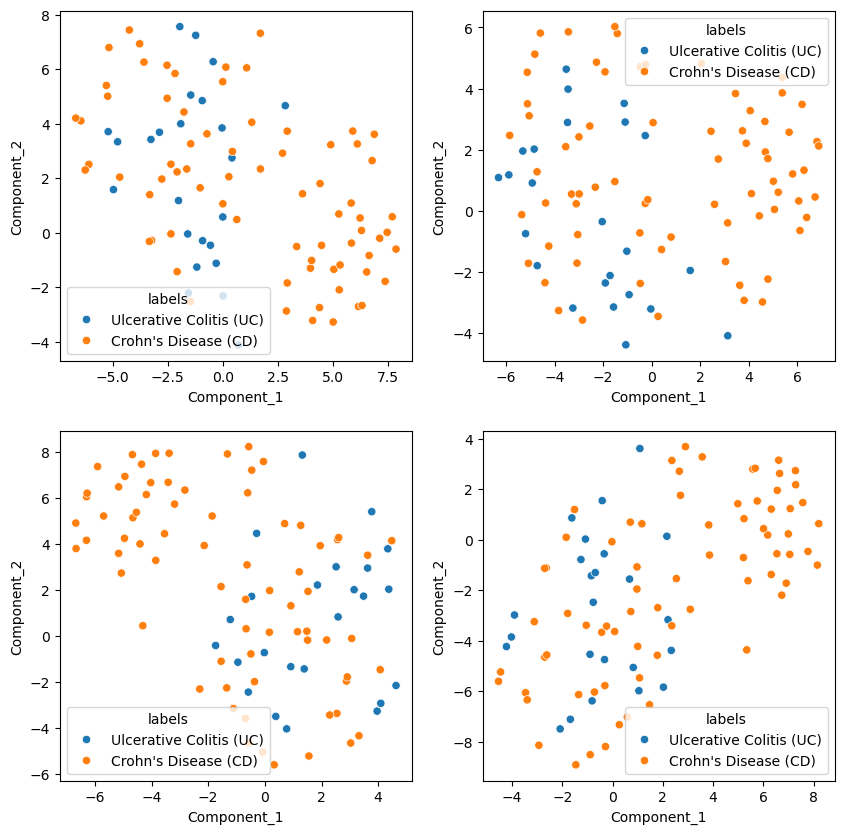

In [174]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.flatten()
np.random.seed(4298)
for i in range(4):
    ## Complete the code below  
    gene_TSNE = TSNE(init="random", learning_rate='auto').fit_transform(gene_data)
    pca_projected=plot_pca(gene_TSNE, labels, ax=ax[i])

> Can you see differnces in these projections, and if so are the differences significant?   

> **Answer:** There seem to be small differences between each of these plots. However, none seem significant.   

#### Copyright 2021, 2022, 2023, Stephen F Elston. All rights reserved.